In [95]:
from IPython.display import display, HTML, Markdown

display(Markdown("# IMPORT LIBRARIES"))

# IMPORT LIBRARIES

In [96]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix
)


In [97]:
display(Markdown("# LOAD DATASET"))

# LOAD DATASET

In [98]:
df = pd.read_csv(
    "tokopedia_product_reviews_2025.csv",
    engine="python",
    on_bad_lines="skip"
)

df = df[['review_text', 'rating']]
df = df.dropna()

print("Jumlah data awal:", len(df))
df.head()

Jumlah data awal: 65543


,review_text,rating
0,baru sekali ini terima brg dr belanja online d...,5
1,cocok bgt aku sama telur nya. nga Amis menurut...,5
2,Telornya sudah sampai di rumah dengan kemasan ...,5
3,Telor sudah diterima dengan baik dan tidak ada...,5
4,"Alhamdulillah penjual amanah,Telor nya terbaik...",5


In [99]:
display(Markdown("# LABEL SENTIMENT"))

# LABEL SENTIMENT

In [100]:
df = df[df['rating'] != 3]

# Buat label biner
df['sentiment'] = df['rating'].apply(
    lambda x: 'positive' if x >= 4 else 'negative'
)

print("\nDistribusi sentiment (asli):")
print(df['sentiment'].value_counts())


Distribusi sentiment (asli):
sentiment
positive    63943
negative      798
Name: count, dtype: int64


In [101]:
display(Markdown("# TEXT CLEAN"))

# TEXT CLEAN

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # angka dipertahankan
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_review'] = df['review_text'].apply(clean_text)

df = df[df['clean_review'].str.len() > 0]

print("\nJumlah data setelah cleaning:", len(df))
df[['review_text', 'clean_review']].head()


Jumlah data setelah cleaning: 64533


,review_text,clean_review
0,baru sekali ini terima brg dr belanja online d...,baru sekali ini terima brg dr belanja online d...
1,cocok bgt aku sama telur nya. nga Amis menurut...,cocok bgt aku sama telur nya nga amis menurutk...
2,Telornya sudah sampai di rumah dengan kemasan ...,telornya sudah sampai di rumah dengan kemasan ...
3,Telor sudah diterima dengan baik dan tidak ada...,telor sudah diterima dengan baik dan tidak ada...
4,"Alhamdulillah penjual amanah,Telor nya terbaik...",alhamdulillah penjual amanah telor nya terbaik...


In [103]:
display(Markdown("# SPLIT TRAIN"))

# SPLIT TRAIN

In [104]:
X = df['clean_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nDistribusi TRAIN (asli):")
print(y_train.value_counts())

print("\nDistribusi TEST (asli):")
print(y_test.value_counts())


Distribusi TRAIN (asli):
sentiment
positive    50990
negative      636
Name: count, dtype: int64

Distribusi TEST (asli):
sentiment
positive    12748
negative      159
Name: count, dtype: int64


In [105]:
display(Markdown("# BALANCING TRAIN"))

# BALANCING TRAIN

In [106]:
train_df = pd.DataFrame({
    'text': X_train,
    'label': y_train
})

min_count = train_df['label'].value_counts().min()

train_balanced = (
    train_df
    .groupby('label')
    .sample(n=min_count, random_state=42)
    .reset_index(drop=True)
)

print("\nDistribusi TRAIN setelah balancing:")
print(train_balanced['label'].value_counts())


Distribusi TRAIN setelah balancing:
label
negative    636
positive    636
Name: count, dtype: int64


In [107]:
display(Markdown("# TF-IDF VECTORIZER"))

# TF-IDF VECTORIZER

In [108]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_train_vec = vectorizer.fit_transform(train_balanced['text'])
X_test_vec = vectorizer.transform(X_test)

y_train_bal = train_balanced['label']

In [109]:
display(Markdown("# MODEL TRAIN"))

# MODEL TRAIN

In [110]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train_bal)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [111]:
display(Markdown("# EVALUATION"))

# EVALUATION

In [112]:
y_pred = model.predict(X_test_vec)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

    negative       0.08      0.96      0.14       159
    positive       1.00      0.85      0.92     12748

    accuracy                           0.86     12907
   macro avg       0.54      0.91      0.53     12907
weighted avg       0.99      0.86      0.91     12907



In [113]:
display(Markdown("# CONFUSSION MATRIX"))

# CONFUSSION MATRIX

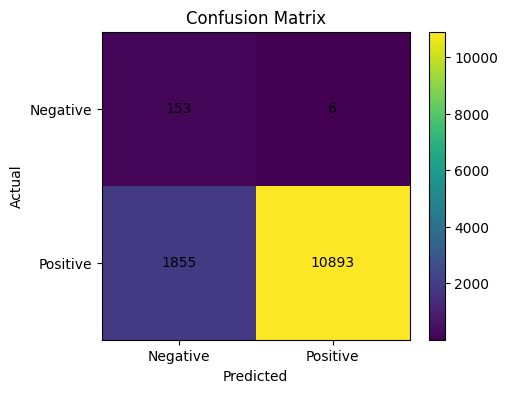

In [114]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1], ['Negative', 'Positive'])
plt.yticks([0,1], ['Negative', 'Positive'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()

In [115]:
display(Markdown("# FEATURE IMPORTANCE"))

# FEATURE IMPORTANCE

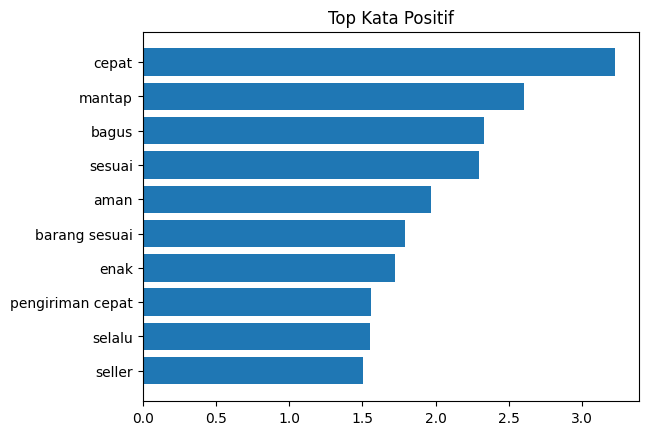

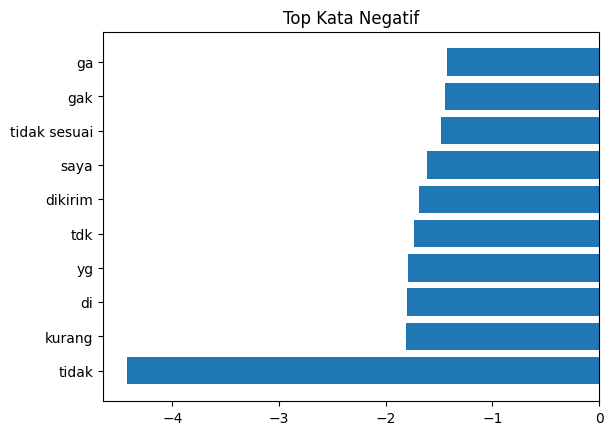

In [116]:
feature_names = vectorizer.get_feature_names_out()
coef = model.coef_[0]

top_positive = np.argsort(coef)[-10:]
top_negative = np.argsort(coef)[:10]

plt.barh(feature_names[top_positive], coef[top_positive])
plt.title("Top Kata Positif")
plt.show()

plt.barh(feature_names[top_negative], coef[top_negative])
plt.title("Top Kata Negatif")
plt.show()

In [117]:
display(Markdown("# SAVE MODEL"))

# SAVE MODEL

In [118]:
joblib.dump(model, "sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Model & vectorizer berhasil disimpan.")

Model & vectorizer berhasil disimpan.


In [119]:
display(Markdown("# PREDICTION FUNCTION"))

# PREDICTION FUNCTION

In [120]:
def predict_sentiment(text):
    text_clean = clean_text(text)
    vector = vectorizer.transform([text_clean])
    return model.predict(vector)[0]

In [121]:
display(Markdown("# PREVIEW"))

# PREVIEW

In [122]:
predict_sentiment("Barangnya bagus dan pengiriman cepat")

'positive'

In [123]:
predict_sentiment("Barang jelek dan tidak sesuai")

'negative'